In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
#from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

2024-03-26 21:14:51.961986: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-26 21:14:51.962116: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-26 21:14:52.080753: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, BatchNormalization, MaxPooling2D, Flatten, Conv2D, Activation, Dropout, concatenate
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
import keras.layers as kl  # Importing keras.layers and aliasing it as kl

# Load images and map to metadata
def load_images_and_map_to_metadata(df, image_folder):
    image_data = []
    labels = []
    for index, row in df.iterrows():
        image_id = row['image_id'] + '.jpg'
        image_path = os.path.join(image_folder, image_id)
        if os.path.exists(image_path):
            image = Image.open(image_path)
            image_data.append(np.array(image))
            labels.append(row['dx'])
    return np.array(image_data), np.array(labels)

# Load metadata
dftrain = pd.read_csv('../input/HAM10000_metadata')
train_image_folder = '../input/ham10k resized/ham10k resized'



In [4]:
# Load metadata
dftest = pd.read_csv('../input/ISIC2018_Task3_Test_GroundTruth.csv')
test_image_folder = '../input/isci test/isci test'



In [5]:
from keras.layers import Layer

class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x

        
        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC
    
        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]
        
        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape
        

        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))

        
        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1) 
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)

        
        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)       
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))
   
            x_exp = K.expand_dims(x,axis=-2)
   
            u = kl.Multiply()([exp_softmax_alpha, x_exp])   
  
            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])   

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u
        
        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape): 
        return [self.out_features_shape, self.out_attention_maps_shape]

    
    def get_config(self):
        return super(SoftAttention,self).get_config()

In [6]:
X_train,y_train= load_images_and_map_to_metadata(dftrain, train_image_folder)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [7]:
X_test,y_test= load_images_and_map_to_metadata(dftest, test_image_folder)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random

In [8]:
from tensorflow.keras import backend as K
y_train=np.array(y_train)
# Reshape y to a 2D array with a single column
y_train= y_train.reshape(-1, 1)

# One-hot encode y
encoder = OneHotEncoder(sparse=False)
y_train = encoder.fit_transform(y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:
print(encoder.categories_)

[array(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'], dtype='<U5')]


In [10]:
# Assuming encoder is your OneHotEncoder instance
index_to_class_mapping = {index: category for index, category in enumerate(encoder.categories_[0])}
print(index_to_class_mapping)


{0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}


In [11]:
from tensorflow.keras import backend as K
y_test=np.array(y_test)
# Reshape y to a 2D array with a single column
y_test = y_test.reshape(-1, 1)

# One-hot encode y
encoder = OneHotEncoder(sparse=False)
y_test = encoder.fit_transform(y_test)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [12]:
# Assuming 'encoder' is your OneHotEncoder object after fitting
class_labels = encoder.categories_[0]  # Get the list of classes

# Create a dictionary mapping from the encoded index (position) back to the class label
index_to_class = {i: class_labels[i] for i in range(len(class_labels))}

# To see the mapping
print("Index to class mapping:", index_to_class)

# If you want to also create a mapping from class label to index:
class_to_index = {class_labels[i]: i for i in range(len(class_labels))}

# To see the reverse mapping
print("Class to index mapping:", class_to_index)


Index to class mapping: {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}
Class to index mapping: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


from imblearn.over_sampling import RandomOverSampler

# Assuming original shape of Data is (n_samples, height, width, channels)
# Flatten Data to 2D
Data=X
Data_flattened = Data.reshape(Data.shape[0], -1)  # Reshape to (n_samples, height*width*channels)

# Create an instance of RandomOverSampler
oversample = RandomOverSampler()

# Apply over-sampling on the flattened data
Data_resampled, y_resampled = oversample.fit_resample(Data_flattened, y)

# Reshape Data back to its original 4D shape after oversampling
# You need the new number of samples after resampling, which is the first dimension of Data_resampled
new_n_samples = Data_resampled.shape[0]
original_height = Data.shape[1]
original_width = Data.shape[2]
original_channels = Data.shape[3]
Data_resampled_4D = Data_resampled.reshape(new_n_samples, original_height, original_width, original_channels)

print('Reshaped Data shape:', Data_resampled_4D.shape)


In [13]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
from tensorflow.keras import backend as K



In [14]:
from keras.layers import Activation



In [15]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.3
                                            , min_lr=0.00001)

In [16]:
y_train_labels = np.argmax(y_train, axis=1)
from sklearn.utils import class_weight
# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [17]:
class_weights_dict

{0: 4.436323366555925,
 1: 2.71869697997964,
 2: 1.3140888961784485,
 3: 13.155993431855501,
 4: 1.2903849251087132,
 5: 0.2132609332162155,
 6: 9.459268004722551}

In [18]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Activation, BatchNormalization, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0

# Assuming SoftAttention is properly defined/imported somewhere in your script
# from your_attention_module import SoftAttention

# Load EfficientNetB0 model
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(400, 400, 3))
base_model.trainable = False

# Original model processing
inputs = base_model.output
conv = MaxPooling2D(pool_size=(2, 2), padding="same")(inputs)
conv = BatchNormalization()(conv)

# Convolutional layers before attention
conv = Conv2D(filters=512, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=512, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=512, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = MaxPooling2D(pool_size=(4, 4), padding="same")(conv)

# Adding the attention mechanism here, just before the dense layers
attention_layer, map2 = SoftAttention(aggregate=True, m=16, concat_with_x=False, ch=int(conv.shape[-1]), name='soft_attention')(conv)
attention_layer = MaxPooling2D(pool_size=(2, 2), padding="same")(attention_layer)
attention_layer = Flatten()(attention_layer)

# Dense layers
dense_layer = Dense(4096, activation="relu")(attention_layer)
dense_layer = Dropout(0.5)(dense_layer)  # Optional: Dropout for regularization
dense_layer = Dense(4096, activation="relu")(dense_layer)
output = Dense(7, activation="softmax")(dense_layer)

# Create the model
model = Model(inputs=base_model.input, outputs=output)



16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
 # Combine base model and top layers
model = Model(inputs=base_model.input, outputs=output)
# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

In [20]:
from tensorflow.keras.optimizers import Adam

# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [21]:




# Model summary
#model.summary()

In [22]:

#model.summary()





In [23]:
import tensorflow as tf

In [24]:
# Train-validation split
x_train, X_val, y_train_encoded, y_val_encoded = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Define checkpoint to save the best model weights
checkpoint = ModelCheckpoint('best_model_weights.keras', 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

# Train the model with the checkpoint callback class_weight=class_weights_dict,
history = model.fit(x_train, y_train_encoded,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val_encoded),
                    )
model.save_weights('my_model.weights.h5')

Epoch 1/50
  1/226 ━━━━━━━━━━━━━━━━━━━━ 2:51:37 46s/step - accuracy: 0.0625 - loss: 9.2193

I0000 00:00:1711487829.109055      69 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


226/226 ━━━━━━━━━━━━━━━━━━━━ 105s 264ms/step - accuracy: 0.5940 - loss: 9.9630 - val_accuracy: 0.6721 - val_loss: 1.0023
Epoch 2/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.6612 - loss: 0.9980 - val_accuracy: 0.6509 - val_loss: 0.9160
Epoch 3/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.6834 - loss: 0.9041 - val_accuracy: 0.6895 - val_loss: 0.8272
Epoch 4/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.6972 - loss: 0.8360 - val_accuracy: 0.6908 - val_loss: 0.8345
Epoch 5/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - accuracy: 0.7047 - loss: 0.7883 - val_accuracy: 0.7170 - val_loss: 0.8843
Epoch 6/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.7203 - loss: 0.7475 - val_accuracy: 0.7444 - val_loss: 0.7694
Epoch 7/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.7512 - loss: 0.6772 - val_accuracy: 0.7569 - val_loss: 1.0235
Epoch 8/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.7758 - loss: 0.6440 - val_accur

In [25]:
# Step 3: Evaluate the Model
y_pred = model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_val_encoded, axis=1)



26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 311ms/step


In [26]:
from sklearn.metrics import classification_report

report = classification_report(y_test_labels, y_pred_labels)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       0.32      0.52      0.40        23
           1       0.60      0.67      0.63        45
           2       0.58      0.58      0.58        91
           3       0.36      0.44      0.40         9
           4       0.70      0.52      0.60        98
           5       0.91      0.92      0.92       529
           6       1.00      0.71      0.83         7

    accuracy                           0.80       802
   macro avg       0.64      0.62      0.62       802
weighted avg       0.81      0.80      0.80       802



In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import jaccard_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score


accuracy = accuracy_score(y_test_labels, y_pred_labels)
print('Accuracy:', accuracy)

# Compute precision
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
print('Precision:', precision)

# Compute recall
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
print('Recall:', recall)

# Compute F1 score
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
print('F1 score:', f1)

# Compute Jaccard coefficient
jaccard = jaccard_score(y_test_labels, y_pred_labels, average='weighted')
print('Jaccard coefficient:', jaccard)

# Compute Dice coefficient
dice = 2 * (precision * recall) / (precision + recall)
print('Dice coefficient:', dice)

Accuracy: 0.8029925187032418
Precision: 0.8101169925278199
Recall: 0.8029925187032418
F1 score: 0.8039314308214427
Jaccard coefficient: 0.7016045232773761
Dice coefficient: 0.8065390226082788


In [28]:
import numpy as np

# Get raw predictions
raw_predictions = model.predict(X_val)

# Convert raw predictions to probabilities using softmax function
y_pred_probs = np.exp(raw_predictions) / np.sum(np.exp(raw_predictions), axis=1, keepdims=True)


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step


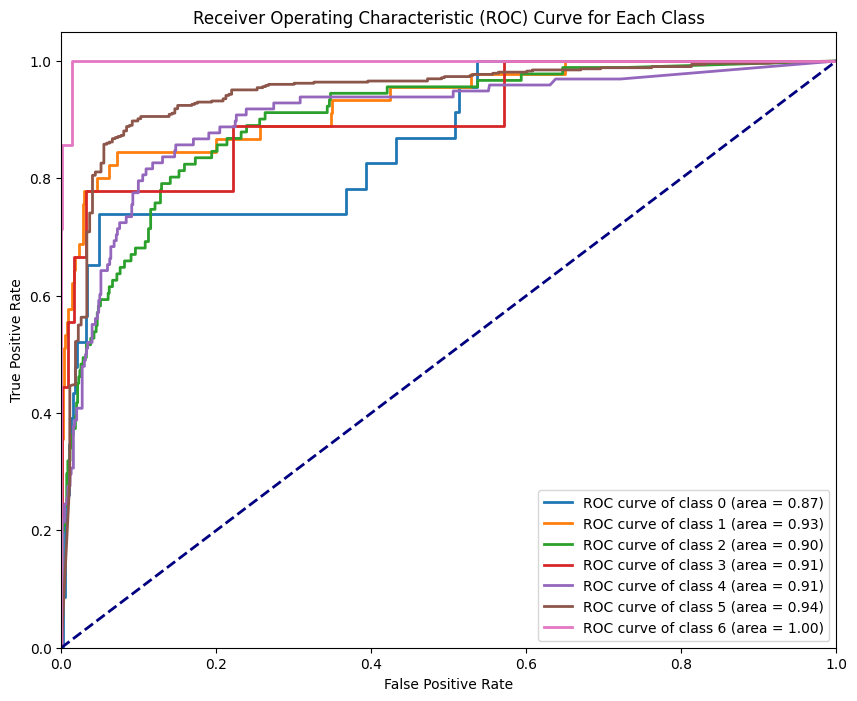

In [29]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_pred_probs contains the predicted probabilities for each class

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test_labels == i, y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(7):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Class')
plt.legend(loc="lower right")
plt.show()


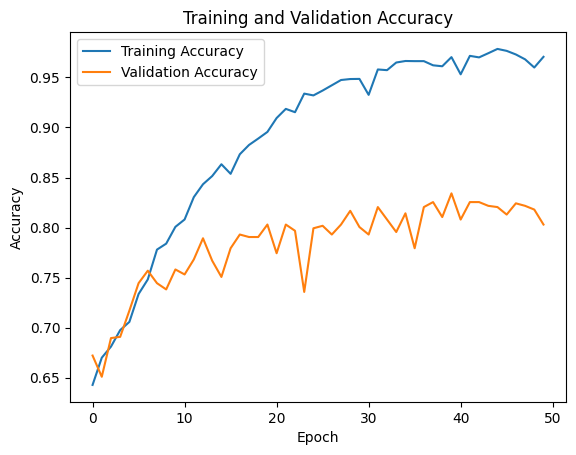

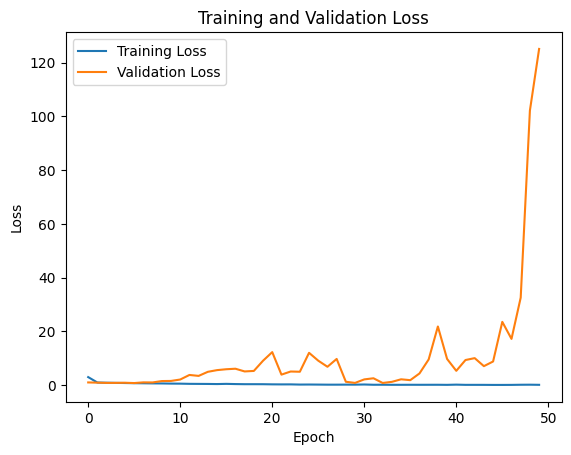

In [30]:
import matplotlib.pyplot as plt
# Plot training and validation accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

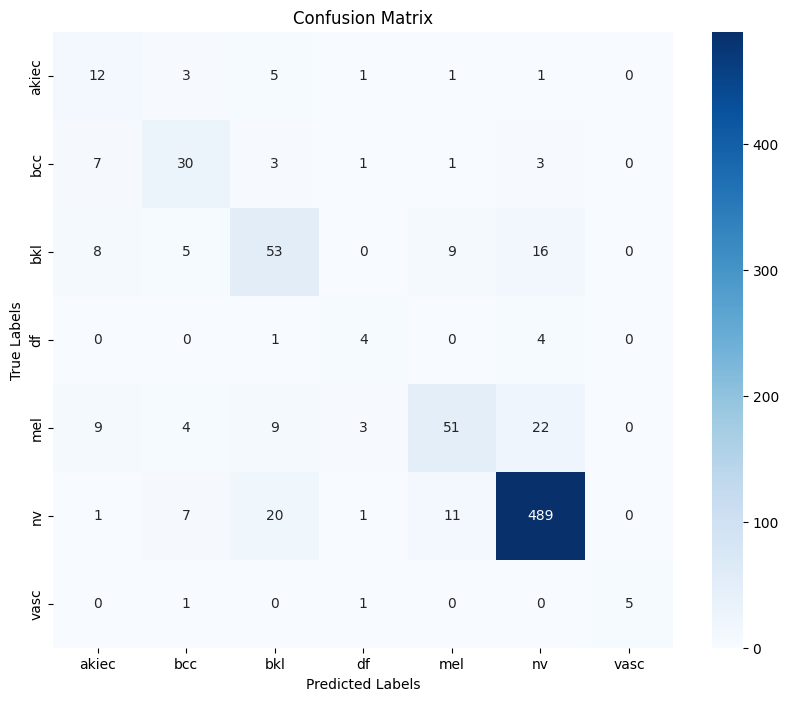

In [31]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


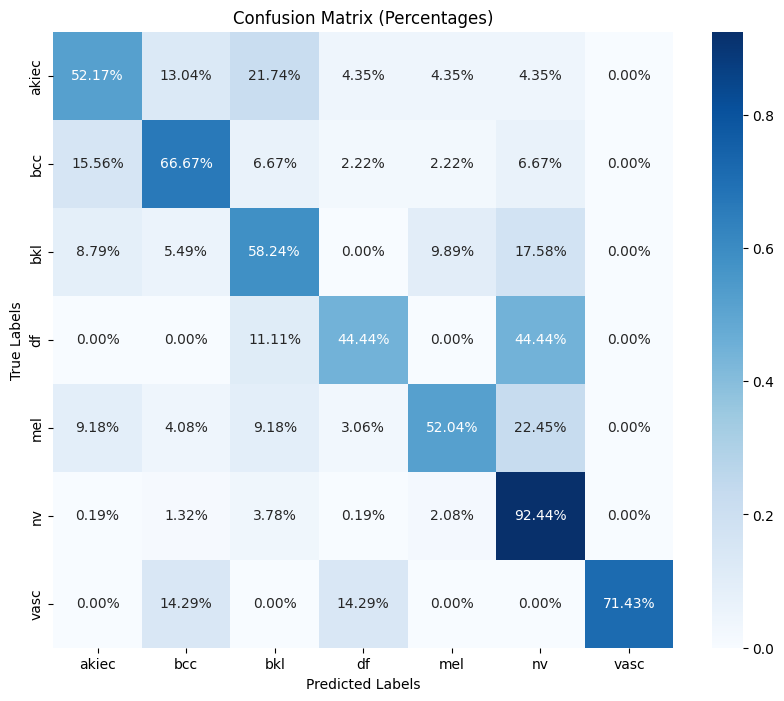

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_test_labels are your true labels and y_pred_labels are your predicted labels

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

# Normalize the confusion matrix by row (i.e. by the number of samples in each true class)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Percentages)')
plt.show()
